# Xception for Pistachio Classification

The "Pistachio Classification Using Xception Model" project aims to develop an accurate and reliable system for classifying different varieties of pistachios. The classification system will leverage the power of the Xception model, a state-of-the-art deep learning architecture known for its exceptional performance in image classification tasks. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
import os
import random
import tensorflow as tf
from matplotlib.image import imread
from pathlib import Path

In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
pistachio_dir = r'C:\Users\DELL\Desktop\python project\Deep Learning\pistachio\Pistachio_Image_Dataset\Pistachio_Image_Dataset'

In [5]:
image_dir = Path(pistachio_dir)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
image_df.head()

,Filepath,Label
0,C:\Users\DELL\Desktop\python project\Deep Lear...,Kirmizi_Pistachio
1,C:\Users\DELL\Desktop\python project\Deep Lear...,Kirmizi_Pistachio
2,C:\Users\DELL\Desktop\python project\Deep Lear...,Kirmizi_Pistachio
3,C:\Users\DELL\Desktop\python project\Deep Lear...,Kirmizi_Pistachio
4,C:\Users\DELL\Desktop\python project\Deep Lear...,Kirmizi_Pistachio


In [7]:
image_df.tail()

,Filepath,Label
1025,C:\Users\DELL\Desktop\python project\Deep Lear...,Siirt_Pistachio
1026,C:\Users\DELL\Desktop\python project\Deep Lear...,Siirt_Pistachio
1027,C:\Users\DELL\Desktop\python project\Deep Lear...,Siirt_Pistachio
1028,C:\Users\DELL\Desktop\python project\Deep Lear...,Siirt_Pistachio
1029,C:\Users\DELL\Desktop\python project\Deep Lear...,Siirt_Pistachio


In [8]:
image_df.shape

(1030, 2)

In [9]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  1030 non-null   object
 1   Label     1030 non-null   object
dtypes: object(2)
memory usage: 16.2+ KB


In [10]:
image_df['Label'].value_counts()

Kirmizi_Pistachio    630
Siirt_Pistachio      400
Name: Label, dtype: int64

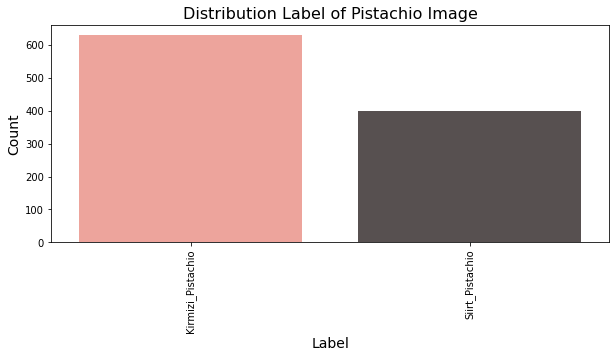

In [11]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(10, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution Label of Pistachio Image', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [12]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(pistachio_dir).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

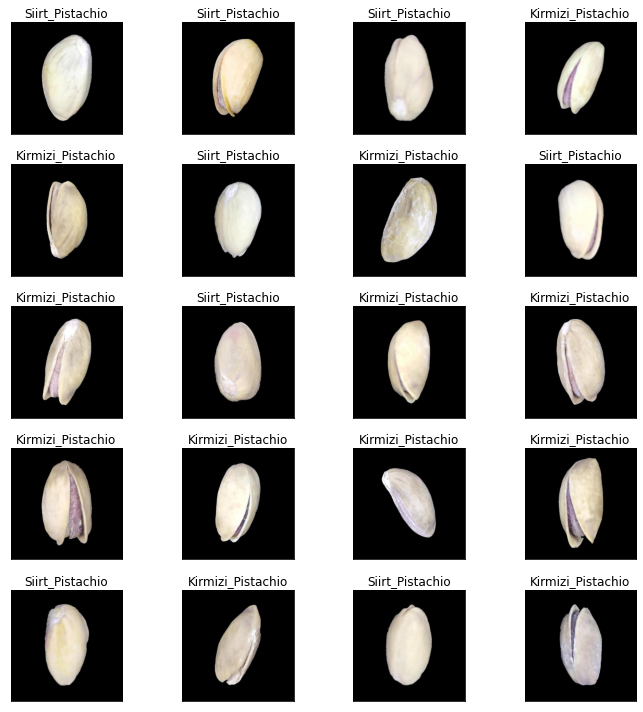

In [13]:
random_index = np.random.randint(0, len(image_df), 20)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_df, test_df = train_test_split(image_df, 
                                     test_size = 0.2, 
                                     shuffle = True, 
                                     random_state = 42)

In [16]:
train_df.shape, test_df.shape

((824, 2), (206, 2))

In [17]:
from tensorflow.keras import Model
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [18]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

In [19]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 660 validated image filenames belonging to 2 classes.


In [20]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 164 validated image filenames belonging to 2 classes.


In [21]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 206 validated image filenames belonging to 2 classes.


In [22]:
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [23]:
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [24]:
checkpoint_path = "pistachio_image_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [25]:
early_stopping = EarlyStopping(monitor = "val_loss", 
                               patience = 3,
                               restore_best_weights = True)

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [27]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

In [28]:
model = Model(inputs=inputs, outputs=outputs)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

def create_tensorboard_callback(log_dir, experiment_name):
    log_dir = log_dir + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [32]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "pistachio_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pistachio_classification/20230625-112050
Epoch 1/15
21/21 [==============================] - 507s 24s/step - loss: 0.8395 - accuracy: 0.5576 - val_loss: 0.7000 - val_accuracy: 0.6098 - lr: 1.0000e-04
Epoch 2/15
21/21 [==============================] - 542s 26s/step - loss: 0.7784 - accuracy: 0.5576 - val_loss: 0.6277 - val_accuracy: 0.6098 - lr: 1.0000e-04
Epoch 3/15
21/21 [==============================] - 564s 27s/step - loss: 0.7271 - accuracy: 0.5712 - val_loss: 0.6021 - val_accuracy: 0.6098 - lr: 1.0000e-04
Epoch 4/15
21/21 [==============================] - 518s 25s/step - loss: 0.6903 - accuracy: 0.6152 - val_loss: 0.5644 - val_accuracy: 0.6463 - lr: 1.0000e-04
Epoch 5/15
21/21 [==============================] - 483s 23s/step - loss: 0.6220 - accuracy: 0.6667 - val_loss: 0.5514 - val_accuracy: 0.6402 - lr: 1.0000e-04
Epoch 6/15
21/21 [==============================] - 605s 29s/step - loss: 0.5947 - accuracy: 0.6788 - val_loss: 0.518

In [33]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.39015
Test Accuracy: 83.50%


In [34]:
model.save('pistachio_classifier_model.h5')

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

<Figure size 432x288 with 0 Axes>

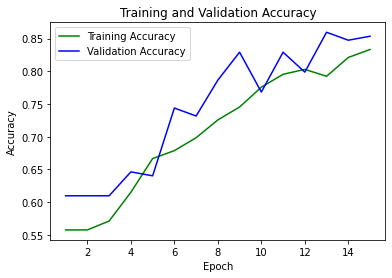

<Figure size 432x288 with 0 Axes>

In [36]:
#accuracy
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

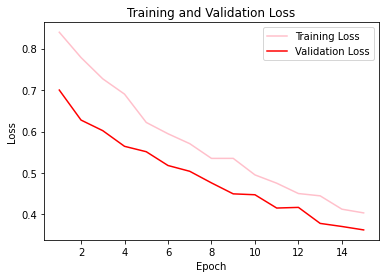

In [37]:
# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

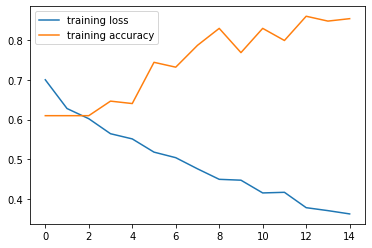

In [38]:
plt.plot(history.history['val_loss'], label = 'training loss')
plt.plot(history.history['val_accuracy'], label = 'training accuracy')
plt.legend()

In [40]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

7/7 [==============================] - 145s 20s/step


In [41]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

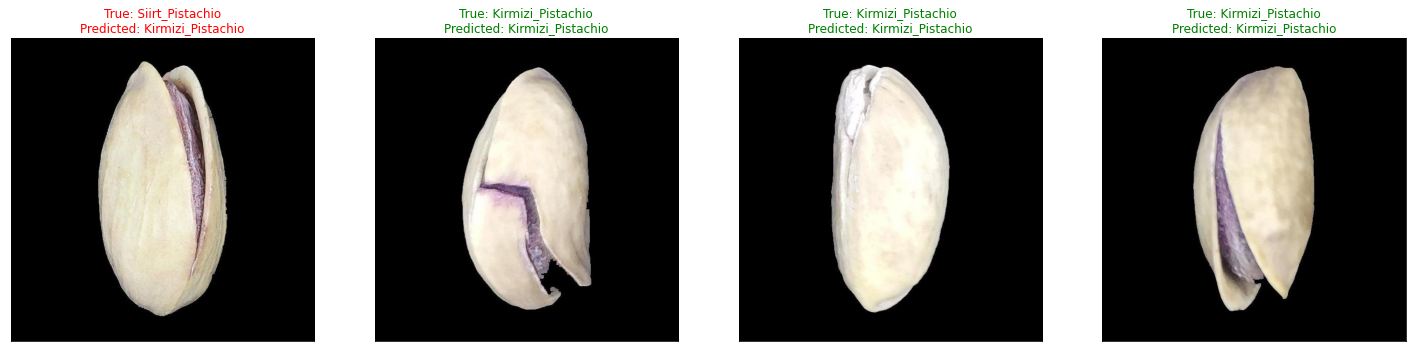

<Figure size 432x288 with 0 Axes>

In [42]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

The "Pistachio Classification Using Xception Model" project successfully developed a reliable and accurate system for classifying different varieties of pistachios. By leveraging the power of the Xception model, this project contributes to enhancing the efficiency and accuracy of quality control, grading, and sorting processes in the pistachio industry.